# Applying Convolutional Neural Networks on IMDB Dataset

**Authors:** Gabriel Novais and Franklin Oliveira   <br>
**Main reference:** Tixier, Antoine J.-P. _Notes on Deep Learning for NLP_.  arXiv preprint arXiv:1808.09772 (2018).

-----

In this notebook, we'll apply CNNs on [IMDB dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) to do a classification task. Important comments regarding this application are presented below. 

> - **IMDB dataset:** This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015 and is available in this [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). <br>
> It contains sentences labelled `"positively"` or `"negatively"`. The attributes are text sentences, extracted from reviews of products, movies, and restaurants.

> - **Task:** We intend to do a classification task. Our model will classify each review as `positive` or `negative` based on attributes we provide as input.

> - **Model:** In this example, we've chosen to apply Convolutional Neural Networks (CNNs) as we were required to apply Neural Networks in an NLP task as a final project of the Machine Learning Course of [EMAp/FGV](https://emap.fgv.br/). 

-----

As usual, we'll begin by importing a few things here and there...

In [73]:
import string
import warnings
import numpy as np
import pandas as pd
# from nltk.corpus import stopwords  # stopwords

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.model_selection import train_test_split

# keras
from keras.models import Model, load_model                                       # models
from keras.callbacks import EarlyStopping, ModelCheckpoint                       # callbacks
from keras.preprocessing.text import Tokenizer                                   # preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D   # layers
from keras.layers import Dense, Concatenate

### Settings
warnings.filterwarnings('ignore')    # filtering warnings to get cleaner outputs

## Importing data

In [42]:
df = pd.read_table('imdb.txt', header=0)
df.head()

,msg,positive
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


As we can see in the cell above, our dataset is in a `pandas.dataframe`, with two columns:

> - **msg:** Review text (full string). To work with this data, we'll need to tokenize, clean up a little bit and (maybe) stemmize.
> - **positive:** Reviews polarization (classification). 1 for positive and 0 for negative reviews, respectively.

In [43]:
print(f'The dataset has {df.shape[0]} reviews.')

pos_rev = df[df['positive']==1].shape[0]
neg_rev = df[df['positive']==0].shape[0]
print(f'{pos_rev} are classified as positive and {neg_rev} as negative.')

The dataset has 748 reviews.
386 are classified as positive and 362 as negative.


In the following cell, a sample review is printed. 

In [44]:
n = np.random.randint(df.shape[0])     # randomly chooses a row to be displayed
print(f'printing review number {n}')
df['msg'].iloc[n]

printing review number 447


"This movie is so mind-bendingly awful, it couldn't have even been created.  "

## Treating messages

Now, let's take some tome to prepare our data. First, we'll tokenize all texts, remove special characters and lower all cases.

As `Tixier (2017)` mentions, 

> "Here, we don't remove any stopwords as some of them might be useful for classification ('but','not', etc.) and the model is supposed to be pretty robust to the presence of unpredictive features, as it automatically learns which features are the most discriminative."

In [45]:
# defining parameters
max_words = 1000   # to cut some very long reviews (just in case)
max_seq_words = 100
dimension = 100

# sw = stopwords.words('english') + list(string.punctuation) # set of english stopwords + special characters

In [46]:
tokenizer = Tokenizer(num_words=max_words, filters=string.punctuation, lower=True)  # instance of tokenizer
tokenizer.fit_on_texts(df['msg'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3180 unique tokens.


## Truncation and padding

As we are dealing with convolutional networks, we need to determine some spacial parameters, such as `padding`. 

We've already truncated reviews higher with more than `max_words` in the previous section.

In [60]:
# checking tensor shape
X = tokenizer.texts_to_sequences(df['msg'].values)
X = pad_sequences(X, maxlen=max_words)         # padding  (max_words or max_seq_words?)
Y = df['positive'].values
print('Shape of data tensor:', X.shape)

Shape of data tensor: (748, 1000)


## Train_test_split

In [61]:
ts = 0.20       #test_size
rs = 1995       #random_state

# train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = ts,random_state = rs)

print('X train shape:', X_train.shape,'\tY train shape:',Y_train.shape)
print('X test shape:' ,X_test.shape,'\tY test shape:', Y_test.shape)

X train shape: (598, 1000) 	Y train shape: (598,)
X test shape: (150, 1000) 	Y test shape: (150,)


## Training CNNs

Now we have our database ready for our Deep Learning model. First things first, let's set up a few things.

### parameters

In [102]:
max_features = int(2e4)
stpwd_thd = 1 
max_size = 200
word_vector_dim = int(3e2)
do_static = False
nb_filters = 150
filter_size_a = 2
filter_size_b = 3
filter_size_c = 4
drop_rate = 0.3
batch_size = 32
epochs = 10
optimizer = 'adam'          # O QUE É?
patience = 3

### Structure presets

<img src="https://github.com/Tixierae/deep_learning_NLP/raw/master/CNN_IMDB/cnn_illustration.png" alt="Drawing" style="width: 400px;"/>

We'll use the same structure of CNN presented in the picture.

In [103]:
my_input = Input(shape=(max_words,)) # we leave the 2nd argument of shape blank because the Embedding layer cannot accept an input_shape argument

embedding = Embedding(input_dim=max_features + 1,
                      output_dim=word_vector_dim,
                      trainable=not do_static,
                      ) (my_input)

embedding_dropped = Dropout(drop_rate)(embedding)

# feature map size should be equal to max_size-filter_size+1
# tensor shape after conv layer should be (feature map size, nb_filters)
print('branch A:',nb_filters,'feature maps of size',max_size-filter_size_a+1)
print('branch B:',nb_filters,'feature maps of size',max_size-filter_size_b+1)

# part A (filter size=2)
conv_a = Conv1D(filters = nb_filters,
              kernel_size = filter_size_a,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_a = GlobalMaxPooling1D()(conv_a)

pooled_conv_dropped_a = Dropout(drop_rate)(pooled_conv_a)

# part B (filter size=3)
conv_b = Conv1D(filters = nb_filters,
              kernel_size = filter_size_b,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_b = GlobalMaxPooling1D()(conv_b)

pooled_conv_dropped_b = Dropout(drop_rate)(pooled_conv_b)


# part C (filter size=4)
conv_c = Conv1D(filters = nb_filters,
              kernel_size = filter_size_c,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_c = GlobalMaxPooling1D()(conv_c)

pooled_conv_dropped_c = Dropout(drop_rate)(pooled_conv_c)



concat = Concatenate()([pooled_conv_dropped_a,pooled_conv_dropped_b, pooled_conv_dropped_c])

concat_dropped = Dropout(drop_rate)(concat)


# we finally project onto a single unit output layer with sigmoid activation
prob = Dense(units = 1, # dimensionality of the output space
             activation = 'sigmoid',
             )(concat_dropped)

model = Model(my_input, prob)

model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

print('model compiled')

branch A: 150 feature maps of size 199
branch B: 150 feature maps of size 198
model compiled


### Training model

In [104]:
early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=patience,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='./CNN_model.hdf5',
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=0)

historyCNN = model.fit(X_train, 
              Y_train,
              batch_size = batch_size,
              epochs = epochs,
              validation_data = (X_test, Y_test),
              callbacks = [early_stopping,checkpointer])

Train on 598 samples, validate on 150 samples
Epoch 1/10
598/598 [==============================] - 38s 63ms/step - loss: 0.7000 - accuracy: 0.5033 - val_loss: 0.6887 - val_accuracy: 0.5333
Epoch 2/10
598/598 [==============================] - 35s 59ms/step - loss: 0.6648 - accuracy: 0.6254 - val_loss: 0.6758 - val_accuracy: 0.5733
Epoch 3/10
598/598 [==============================] - 34s 56ms/step - loss: 0.6153 - accuracy: 0.7258 - val_loss: 0.6577 - val_accuracy: 0.6200
Epoch 4/10
598/598 [==============================] - 34s 56ms/step - loss: 0.5356 - accuracy: 0.7742 - val_loss: 0.6189 - val_accuracy: 0.6467
Epoch 5/10
598/598 [==============================] - 34s 56ms/step - loss: 0.4135 - accuracy: 0.8612 - val_loss: 0.5445 - val_accuracy: 0.7267
Epoch 6/10
598/598 [==============================] - 33s 56ms/step - loss: 0.2750 - accuracy: 0.9247 - val_loss: 0.4845 - val_accuracy: 0.8000
Epoch 7/10
598/598 [==============================] - 33s 55ms/step - loss: 0.1841 - accur

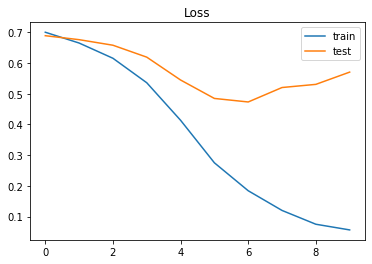

In [105]:
# loss and validation loss
plt.title('Loss')
plt.plot(historyCNN.history['loss'], label='train')
plt.plot(historyCNN.history['val_loss'], label='test')
plt.xlabel('epochs')
plt.legend()
plt.show();

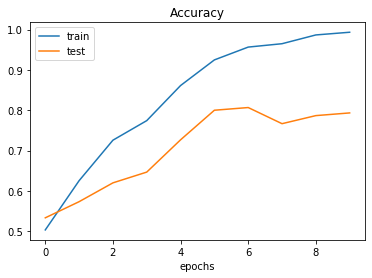

In [106]:
# Accuracy in and out sample
plt.title('Accuracy')
plt.plot(historyCNN.history['accuracy'], label='train')
plt.plot(historyCNN.history['val_accuracy'], label='test')
plt.xlabel('epochs')
plt.legend()
plt.show();

**End**